<a href="https://colab.research.google.com/github/KJ22222/ESSA/blob/main/%EC%88%98%EC%9E%A5%EC%9E%91_%EB%A6%AC%EB%B7%B0%EC%8A%A4%ED%84%B0%EB%94%94_3%EC%A3%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 주차수요 예측 AI 경진대회 수상작 리뷰

# 1.패키지 및 데이터 로딩

In [2]:
import os 
import glob
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

import plotly 
import plotly.express as px
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore')

In [3]:
# plotly 그래프 업로드
pd.options.plotting.backend = 'plotly'
import plotly.io as pio
pio.renderers.default = 'notebook_connected'

# 옵션 설정
pd.set_option('display.max_columns', None)
rc('font', family='Malgun Gothic')
matplotlib.rcParams['axes.unicode_minus'] = False

In [4]:
current_directory = os.getcwd()
print(current_directory) 

/content


In [5]:
#구글 드라이브와 연동
from google.colab import drive
drive.mount('/content/gdrive')
directory_path = '/content/gdrive/My Drive/Colab Notebooks/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
submission = pd.read_csv('/content/sample_submission.csv')

# 2. 데이터 탐색

In [7]:
train.shape, test.shape

((2952, 15), (1022, 14))

In [8]:
train.head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
0,C2483,900,아파트,경상북도,국민임대,39.72,134,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
1,C2483,900,아파트,경상북도,국민임대,39.72,15,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
2,C2483,900,아파트,경상북도,국민임대,51.93,385,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0
3,C2483,900,아파트,경상북도,국민임대,51.93,15,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0
4,C2483,900,아파트,경상북도,국민임대,51.93,41,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0


In [9]:
test.head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
0,C1072,754,아파트,경기도,국민임대,39.79,116,14.0,H,22830000,189840,0.0,2.0,683.0
1,C1072,754,아파트,경기도,국민임대,46.81,30,14.0,A,36048000,249930,0.0,2.0,683.0
2,C1072,754,아파트,경기도,국민임대,46.90,112,14.0,H,36048000,249930,0.0,2.0,683.0
3,C1072,754,아파트,경기도,국민임대,46.90,120,14.0,H,36048000,249930,0.0,2.0,683.0
4,C1072,754,아파트,경기도,국민임대,51.46,60,14.0,H,43497000,296780,0.0,2.0,683.0


## 1) 컬럼명 변경  

In [10]:
train.columns = [
    '단지코드', '총세대수', '임대건물구분', '지역', '공급유형', 
    '전용면적', '전용면적별세대수', '공가수', '자격유형', '임대보증금',
    '임대료', '지하철', '버스', '단지내주차면수', '등록차량수'
]

test.columns = [
    '단지코드', '총세대수', '임대건물구분', '지역', '공급유형', 
    '전용면적', '전용면적별세대수', '공가수', '자격유형', '임대보증금', 
    '임대료', '지하철', '버스', '단지내주차면수'
]

##  2) 데이터 타입 및 결측치 확인

train data

In [11]:
train.dtypes, train.isnull().sum()

(단지코드         object
 총세대수          int64
 임대건물구분       object
 지역           object
 공급유형         object
 전용면적        float64
 전용면적별세대수      int64
 공가수         float64
 자격유형         object
 임대보증금        object
 임대료          object
 지하철         float64
 버스          float64
 단지내주차면수     float64
 등록차량수       float64
 dtype: object, 단지코드          0
 총세대수          0
 임대건물구분        0
 지역            0
 공급유형          0
 전용면적          0
 전용면적별세대수      0
 공가수           0
 자격유형          0
 임대보증금       569
 임대료         569
 지하철         211
 버스            4
 단지내주차면수       0
 등록차량수         0
 dtype: int64)

test data

In [12]:
test.dtypes, test.isnull().sum()

(단지코드         object
 총세대수          int64
 임대건물구분       object
 지역           object
 공급유형         object
 전용면적        float64
 전용면적별세대수      int64
 공가수         float64
 자격유형         object
 임대보증금        object
 임대료          object
 지하철         float64
 버스          float64
 단지내주차면수     float64
 dtype: object, 단지코드          0
 총세대수          0
 임대건물구분        0
 지역            0
 공급유형          0
 전용면적          0
 전용면적별세대수      0
 공가수           0
 자격유형          2
 임대보증금       180
 임대료         180
 지하철          42
 버스            0
 단지내주차면수       0
 dtype: int64)

#3.전처리

## 1) 결측치 대체

- train data -> 지하철 & 버스 결측치 0으로 대체  

- test data -> 지하철 결측치 0으로 대체

In [13]:
train[['지하철', '버스']] = train[['지하철', '버스']].fillna('0').astype(int)
test[['지하철']] = test[['지하철']].fillna('0'). astype(int)

자격유형
- 단지코드 C2411 / C2253 자격유형 결측치  
- 단지코드, 임대건물구분, 지역 등이 동일한 샘플의 자격유형 값을 참고하여 대체  
+ C2411 자격유형 → 'A'
+ C2253 자격유형 → 'C'

In [14]:
test[test.자격유형.isnull()]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수
196,C2411,962,아파트,경상남도,국민임대,46.90,240,25.0,NaN,71950000,37470,0,2.0,840.0
258,C2253,1161,아파트,강원도,영구임대,26.37,745,0.0,NaN,2249000,44770,0,2.0,173.0


In [15]:
test[(test.단지코드=='C2411') | (test.단지코드=='C2253')].head(10)

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수
193,C2411,962,아파트,경상남도,국민임대,39.43,56,25.0,A,11992000,100720,0,2.0,840.0
194,C2411,962,아파트,경상남도,국민임대,39.72,336,25.0,A,11992000,100720,0,2.0,840.0
195,C2411,962,아파트,경상남도,국민임대,39.82,179,25.0,A,11992000,100720,0,2.0,840.0
196,C2411,962,아파트,경상남도,국민임대,46.90,240,25.0,NaN,71950000,37470,0,2.0,840.0
197,C2411,962,아파트,경상남도,국민임대,51.93,150,25.0,A,21586000,171480,0,2.0,840.0
258,C2253,1161,아파트,강원도,영구임대,26.37,745,0.0,NaN,2249000,44770,0,2.0,173.0
259,C2253,1161,아파트,강원도,영구임대,31.32,239,0.0,C,3731000,83020,0,2.0,173.0
260,C2253,1161,아파트,강원도,영구임대,31.32,149,0.0,C,3731000,83020,0,2.0,173.0
261,C2253,1161,상가,강원도,임대상가,13.77,1,0.0,D,NaN,NaN,0,2.0,173.0
262,C2253,1161,상가,강원도,임대상가,22.89,1,0.0,D,NaN,NaN,0,2.0,173.0


In [16]:
test.loc[(test.단지코드=='C2411')&(test.자격유형.isnull()), '자격유형'] = 'A'
test.loc[(test.단지코드=='C2253')&(test.자격유형.isnull()), '자격유형'] = 'C'

test[(test.단지코드=='C2411') | (test.단지코드=='C2253')].head(10)

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수
193,C2411,962,아파트,경상남도,국민임대,39.43,56,25.0,A,11992000,100720,0,2.0,840.0
194,C2411,962,아파트,경상남도,국민임대,39.72,336,25.0,A,11992000,100720,0,2.0,840.0
195,C2411,962,아파트,경상남도,국민임대,39.82,179,25.0,A,11992000,100720,0,2.0,840.0
196,C2411,962,아파트,경상남도,국민임대,46.90,240,25.0,A,71950000,37470,0,2.0,840.0
197,C2411,962,아파트,경상남도,국민임대,51.93,150,25.0,A,21586000,171480,0,2.0,840.0
258,C2253,1161,아파트,강원도,영구임대,26.37,745,0.0,C,2249000,44770,0,2.0,173.0
259,C2253,1161,아파트,강원도,영구임대,31.32,239,0.0,C,3731000,83020,0,2.0,173.0
260,C2253,1161,아파트,강원도,영구임대,31.32,149,0.0,C,3731000,83020,0,2.0,173.0
261,C2253,1161,상가,강원도,임대상가,13.77,1,0.0,D,NaN,NaN,0,2.0,173.0
262,C2253,1161,상가,강원도,임대상가,22.89,1,0.0,D,NaN,NaN,0,2.0,173.0


#### [Train] C1786 | 강원도 | 행복주택 | 총 480세대 : 춘천거두2 행복주택


In [17]:
# 전용면적 16.91 
train.loc[(train['단지코드'] == 'C1786') & (train['전용면적'] == 16.91), '임대보증금'] = 13450000
train.loc[(train['단지코드'] == 'C1786') & (train['전용면적'] == 16.91), '임대료'] = 65500
# 전용면적 26.9
train.loc[(train['단지코드'] == 'C1786') & (train['전용면적'] == 26.9), '임대보증금'] = 19700000
train.loc[(train['단지코드'] == 'C1786') & (train['전용면적'] == 26.9), '임대료'] = 96000
# 전용면적 26.9
train.loc[(train['단지코드'] == 'C1786') & (train['전용면적'] == 26.9), '임대보증금'] = 19150000
train.loc[(train['단지코드'] == 'C1786') & (train['전용면적'] == 26.9), '임대료'] = 94000
# 전용면적 26.9
train.loc[(train['단지코드'] == 'C1786') & (train['전용면적'] == 26.9), '임대보증금'] = 21400000
train.loc[(train['단지코드'] == 'C1786') & (train['전용면적'] == 26.9), '임대료'] = 105000

#### [Train] C1326 | 부산광역시 | 국민임대 | 총 1934세대 : 부산정관 7단지 A-1블록


In [18]:
# 전용면적 24.72
train.loc[(train['단지코드'] == 'C1326') & (train['전용면적'] == 24.72), '임대보증금'] = 7000000
train.loc[(train['단지코드'] == 'C1326') & (train['전용면적'] == 24.72), '임대료'] = 135000
# 전용면적 24.79
train.loc[(train['단지코드'] == 'C1326') & (train['전용면적'] == 24.79), '임대보증금'] = 7000000
train.loc[(train['단지코드'] == 'C1326') & (train['전용면적'] == 24.79), '임대료'] = 135000
# 전용면적 26.83
train.loc[(train['단지코드'] == 'C1326') & (train['전용면적'] == 26.83), '임대보증금'] = 7600000
train.loc[(train['단지코드'] == 'C1326') & (train['전용면적'] == 26.83), '임대료'] = 142000
# 전용면적 37.7
train.loc[(train['단지코드'] == 'C1326') & (train['전용면적'] == 37.7), '임대보증금'] = 14800000
train.loc[(train['단지코드'] == 'C1326') & (train['전용면적'] == 37.7), '임대료'] = 198000
# 전용면적 46.94
train.loc[(train['단지코드'] == 'C1326') & (train['전용면적'] == 46.94), '임대보증금'] = 23100000
train.loc[(train['단지코드'] == 'C1326') & (train['전용면적'] == 46.94), '임대료'] = 259000

#### [Train] C2186 | 대구광역시 | 국민임대 | 총 924세대 : 대구연경 A-2블록 국민임대주택


In [19]:
# 전용면적 29.17
train.loc[(train['단지코드'] == 'C2186') & (train['전용면적'] == 29.17), '임대보증금'] = 10847000
train.loc[(train['단지코드'] == 'C2186') & (train['전용면적'] == 29.17), '임대료'] = 138600
# 전용면적 29.34
train.loc[(train['단지코드'] == 'C2186') & (train['전용면적'] == 29.34), '임대보증금'] = 10847000
train.loc[(train['단지코드'] == 'C2186') & (train['전용면적'] == 29.34), '임대료'] = 138600
# 전용면적 37.43
train.loc[(train['단지코드'] == 'C2186') & (train['전용면적'] == 37.43), '임대보증금'] = 17338000
train.loc[(train['단지코드'] == 'C2186') & (train['전용면적'] == 37.43), '임대료'] = 197500

#### [Test] C2152 | 강원도 | 영구임대 | 총 120세대 : 화천신읍 공공실버주택


In [20]:
# 전용면적 24.83
test.loc[(test['단지코드'] == 'C2152') & (test['전용면적'] == 24.83), '임대보증금'] = 2129000
test.loc[(test['단지코드'] == 'C2152') & (test['전용면적'] == 24.83), '임대료'] = 42350
# 전용면적 33.84
test.loc[(test['단지코드'] == 'C2152') & (test['전용면적'] == 33.84), '임대보증금'] = 2902000
test.loc[(test['단지코드'] == 'C2152') & (test['전용면적'] == 33.84), '임대료'] = 57730

#### [Test] C1267 | 경상남도 | 행복주택 | 총 675세대 : 창원가포 A-1블록 행복주택


In [21]:
# 전용면적 16.94
test.loc[(test['단지코드'] == 'C1267') & (test['전용면적'] == 16.94), '임대보증금'] = 11200000
test.loc[(test['단지코드'] == 'C1267') & (test['전용면적'] == 16.94), '임대료'] = 53200
# 전용면적 26.85
test.loc[(test['단지코드'] == 'C1267') & (test['전용면적'] == 26.85), '임대보증금'] = 16333330
test.loc[(test['단지코드'] == 'C1267') & (test['전용면적'] == 26.85), '임대료'] = 77580
# 전용면적 26.85
test.loc[(test['단지코드'] == 'C1267') & (test['전용면적'] == 26.85), '임대보증금'] = 18620000
test.loc[(test['단지코드'] == 'C1267') & (test['전용면적'] == 26.85), '임대료'] = 88440
# 전용면적 36.77
test.loc[(test['단지코드'] == 'C1267') & (test['전용면적'] == 36.77), '임대보증금'] = 23760000
test.loc[(test['단지코드'] == 'C1267') & (test['전용면적'] == 36.77), '임대료'] = 112860

#### [Test] C1006 | 대전광역시 | 임대상가 | 총 1505세대 : 대전둔산1단지
일부 '영구임대' 아파트 입주 자격유형이 `D`로 되어있음 → `C`로 변경 

In [22]:
# 전용면적 26.37
test.loc[(test['단지코드'] == 'C1006') & (test['전용면적'] == 26.37), '임대보증금'] = 5787000
test.loc[(test['단지코드'] == 'C1006') & (test['전용면적'] == 26.37), '임대료'] = 79980
test.loc[(test['단지코드'] == 'C1006') & (test['전용면적'] == 26.37), '자격유형'] = 'C'
# 전용면적 52.74
test.loc[(test['단지코드'] == 'C1006') & (test['전용면적'] == 52.74), '임대보증금'] = 11574000
test.loc[(test['단지코드'] == 'C1006') & (test['전용면적'] == 52.74), '임대료'] = 159960
test.loc[(test['단지코드'] == 'C1006') & (test['전용면적'] == 52.74), '자격유형'] = 'C'

## 2) 데이터 타입 변경
+ 실제 데이터를 기반으로 대체되지 못한 경우 0으로 대체 후 데이터 타입 int로 변경

In [23]:
train[['임대보증금','임대료']] = train[['임대보증금','임대료']].fillna('0').replace('-','0').astype(int)
test[['임대보증금', '임대료']] = test[['임대보증금', '임대료']].fillna('0').replace('-','0').astype(int)

In [24]:
train.dtypes, train.isnull().sum()

(단지코드         object
 총세대수          int64
 임대건물구분       object
 지역           object
 공급유형         object
 전용면적        float64
 전용면적별세대수      int64
 공가수         float64
 자격유형         object
 임대보증금         int64
 임대료           int64
 지하철           int64
 버스            int64
 단지내주차면수     float64
 등록차량수       float64
 dtype: object, 단지코드        0
 총세대수        0
 임대건물구분      0
 지역          0
 공급유형        0
 전용면적        0
 전용면적별세대수    0
 공가수         0
 자격유형        0
 임대보증금       0
 임대료         0
 지하철         0
 버스          0
 단지내주차면수     0
 등록차량수       0
 dtype: int64)

In [25]:
test.dtypes, test.isnull().sum()

(단지코드         object
 총세대수          int64
 임대건물구분       object
 지역           object
 공급유형         object
 전용면적        float64
 전용면적별세대수      int64
 공가수         float64
 자격유형         object
 임대보증금         int64
 임대료           int64
 지하철           int64
 버스          float64
 단지내주차면수     float64
 dtype: object, 단지코드        0
 총세대수        0
 임대건물구분      0
 지역          0
 공급유형        0
 전용면적        0
 전용면적별세대수    0
 공가수         0
 자격유형        0
 임대보증금       0
 임대료         0
 지하철         0
 버스          0
 단지내주차면수     0
 dtype: int64)

## 3) 오류 데이터 제거
- 공지를 참고하여 오류 데이터 11개 단지 제외

In [26]:
error_data = ['C2085', 'C1397', 'C2431', 'C1649', 'C1095', 'C2051', 'C1218', 'C1894', 'C2483', 'C1502', 'C1988']

for error in error_data:
    error_index = train[train['단지코드'] == error].index
    train.drop(error_index, inplace=True)

In [27]:
train.shape, test.shape

((2876, 15), (1022, 14))

## 4) 파생변수 생성

### 지역

지역 피처의 수준 16개로 비교적 많음  
등록차량수의 중앙값을 기준으로 지역을 5개 그룹(n지역)으로 통합 


* 0 : 대전광역시, 충청남도, 부산광역시, 제주특별자치도
* 1 : 강원도, 경상남도, 울산광역시
* 2 : 전라남도, 전라북도, 충청북도
* 3 : 경상북도, 광주광역시, 서울특별시
* 4 : 경기도, 대구광역시, 세종특별시

In [28]:
px.box(train, x='지역', y='등록차량수', hover_name='단지코드')

In [29]:
# 지역별 샘플수(count)와 등록차량수의 중앙값(median) 산출 후 중앙값 기준으로 정렬
area_groups = pd.DataFrame([
    *pd.DataFrame({
        '지역' : train['지역'],
        '등록차량수' : train['등록차량수'],
    })
    .groupby(['지역'])
    .apply(lambda x: {
        '지역' : x.iloc[0,0],
        'count' : len(x),
        'median' : x.등록차량수.median()
    })
]).sort_values('median')

# 중앙값이 작은 지역부터 누적 샘플크기(cum_count)를 토대로 백분위수를 고려해 5개 그룹으로 분할
area_groups['cum_count'] = np.cumsum(area_groups['count'])
area_groups['n지역'] = pd.qcut(area_groups['cum_count'], 5, labels=False, retbins=False)

to_join = area_groups[['지역', 'n지역']].set_index('지역')
train = train.join(to_join, on='지역')
train['n지역'] = train['n지역'].astype('category')

In [30]:
train = train[['단지코드', '총세대수', '임대건물구분', '지역', 'n지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
       '자격유형', '임대보증금', '임대료', '지하철', '버스', '단지내주차면수', '등록차량수']]

In [31]:
test.insert(4, 'n지역','')
test.loc[(test['지역'] == '대전광역시') | (test['지역'] == '충청남도') | (test['지역'] == '부산광역시') | (test['지역'] == '제주특별자치도'), 'n지역'] = 0
test.loc[(test['지역'] == '강원도') | (test['지역'] == '경상남도') | (test['지역'] == '울산광역시'), 'n지역'] = 1
test.loc[(test['지역'] == '전라남도') | (test['지역'] == '전라북도') | (test['지역'] == '충청북도'), 'n지역'] = 2
test.loc[(test['지역'] == '경상북도') | (test['지역'] == '광주광역시') | (test['지역'] == '서울특별시'), 'n지역'] = 3
test.loc[(test['지역'] == '경기도') | (test['지역'] == '대구광역시') | (test['지역'] == '세종특별자치시'), 'n지역'] = 4

test['n지역'] = test['n지역'].astype('category')

In [32]:
px.box(train, x='n지역', y='등록차량수', hover_name='단지코드')

### 공급유형

공급유형 피처 또한 수준 10개로 비교적 많음  
'등록차량수-단지내주차면수' 차이를 기준으로 공급유형을 5개 그룹(n공급유형)으로 통합 

* 0 : 국민임대
* 1 : 단기공공임대(공공임대(5년)/공공임대(10년)/공공임대(분납)/공공분양)
* 2 : 임대상가
* 3 : 장기공공임대(공공임대(50년))
* 4 : 저소득층(행복주택/영구임대/장기전세)

df

In [33]:
px.box(train, x='공급유형', y='등록차량수', hover_name='단지코드')

In [34]:
tmp = train.copy()
tmp['차이'] = tmp['단지내주차면수'] - tmp['등록차량수']
px.box(tmp, x='공급유형', y='차이', hover_name='단지코드')

In [35]:
# 공급유형 별로 임대유형, 임대기간, 입주조건 등이 상이함 → 차량 보유 여부를 비롯한 사회경제적지위(SES)를 반영할 것으로 예상
# 공급유형 별 특성과 '등록차량수-단지내주차면수' 차이 분포를 고려하여 범주 분류
# 국민임대(가장 많은 공급유형)와 임대상가(아파트와 명확한 임대유형 차이)는 별도의 범주로 분류

train.loc[train['공급유형'].isin(['공공임대(50년)']),'공급유형'] = '장기공공임대'
train.loc[train['공급유형'].isin(['공공임대(5년)', '공공임대(10년)', '공공임대(분납)', '공공분양']),'공급유형'] = '단기공공임대'
train.loc[train['공급유형'].isin(['행복주택', '영구임대', '장기전세']), '공급유형'] = '저소득층'

test.loc[test['공급유형'].isin(['공공임대(50년)']),'공급유형'] = '장기공공임대'
test.loc[test['공급유형'].isin(['공공임대(5년)', '공공임대(10년)', '공공임대(분납)', '공공분양']),'공급유형'] = '단기공공임대'
test.loc[test['공급유형'].isin(['행복주택', '영구임대', '장기전세']), '공급유형'] = '저소득층'

train['n공급유형'] = train.loc[:,'공급유형'].astype('category').cat.codes
test['n공급유형'] = test.loc[:,'공급유형'].astype('category').cat.codes

In [36]:
px.box(train, x='n공급유형', y='등록차량수', hover_name='단지코드')

### 전용면적

5단위로 변환  
+ 전용면적 100 초과 → 100
+ 전용면적 15 미만 → 15 

In [37]:
train['전용면적'] = train['전용면적'] //5*5
train['전용면적'] = np.where(train['전용면적'] > 100, 100, train['전용면적'])
train['전용면적'] = np.where(train['전용면적'] < 15, 15, train['전용면적'])


test['전용면적'] = test['전용면적'] //5*5
test['전용면적'] = np.where(test['전용면적'] > 100, 100, test['전용면적'])
test['전용면적'] = np.where(test['전용면적'] < 15, 15, test['전용면적'])

## 5) 1차원으로 데이터 병합

```
<공급유형 병합 오류> 
단지코드 기준 병합과정에서 공급유형 제대로 반영되지 않음   
동일 단지코드 내에 공급유형 타입 2개 이상으로 나뉘는 경우 있었으나, 가장 상위에 등장한 공급유형으로 통일됨   
  → '임대상가' 유형 완전 제외됨(국민임대, 장기공공임대에 포함됨)
  → '장기공공임대' 유형에 '임대상가', '저소득층' 특성 반영됨
```

공급유형 내에 '임대건물구분', '자격유형'에 대한 정보가 포함되어 있는 것으로 보임 → 다중공선성을 고려하여 피처 제외  

raw 데이터 상 '총세대수' 산정 오류 → 기존 피처 제외하고 전용면적별 세대수를 활용하여 대체 변수 생성('총임대세대수')  

+ 사용 피처 : 단지코드 / n지역 / n공급유형 / 공가수 / 지하철 / 버스 / 단지내주차면수 / 등록차량수
+  제외 피처 : 임대건물구분 / 자격유형 / 총세대수  

전용면적별세대수, 전용면적, 임대보증금, 임대료를 활용한 파생변수 추가 생성

+ 추가 생성 피처 : 총임대세대수 / 평균전용면적 / 총전용면적 / 평균임대보증금 / 평균임대료  

In [38]:
codes = train.단지코드.unique()
areas = np.sort(train.전용면적.unique())

df_train = pd.DataFrame()
columns = ['단지코드', 'n지역', 'n공급유형', '공가수', '지하철', '버스', '단지내주차면수', '등록차량수']

for i, code in enumerate(codes):
    tmp_code = train.loc[train.단지코드 == code].reset_index(drop=True)

    df_train.loc[i, columns] = tmp_code.loc[0, columns]
    df_train.loc[i, '총임대세대수'] = (tmp_code.전용면적별세대수).sum()

    df_train.loc[i, '평균전용면적'] = (tmp_code.전용면적).mean() 
    df_train.loc[i, '총전용면적'] = (tmp_code.전용면적 * tmp_code.전용면적별세대수).sum()
    df_train.loc[i, '평균임대보증금'] = (tmp_code.전용면적별세대수 * tmp_code.임대보증금).sum() / (tmp_code.전용면적별세대수).sum()
    df_train.loc[i, '평균임대료'] = (tmp_code.전용면적별세대수 * tmp_code.임대료).sum() / (tmp_code.전용면적별세대수).sum()

In [39]:
codes = test.단지코드.unique()
areas = np.sort(test.전용면적.unique())

df_test = pd.DataFrame()
columns = ['단지코드', 'n지역', 'n공급유형', '공가수', '지하철', '버스', '단지내주차면수']

for i, code in enumerate(codes):
    tmp_code = test.loc[test.단지코드 == code].reset_index(drop=True)

    df_test.loc[i, columns] = tmp_code.loc[0, columns]
    df_test.loc[i, '총임대세대수'] = (tmp_code.전용면적별세대수).sum()

    df_test.loc[i, '평균전용면적'] = (tmp_code.전용면적).mean() 
    df_test.loc[i, '총전용면적'] = (tmp_code.전용면적 * tmp_code.전용면적별세대수).sum()
    df_test.loc[i, '평균임대보증금'] = (tmp_code.전용면적별세대수 * tmp_code.임대보증금).sum() / (tmp_code.전용면적별세대수).sum()
    df_test.loc[i, '평균임대료'] = (tmp_code.전용면적별세대수 * tmp_code.임대료).sum() / (tmp_code.전용면적별세대수).sum()

# 4.모형 학습, 예측 및 평가

## 1) 단순 회귀(Linear Regression)

### 피처와 타겟 간 상관 확인

단순선형회귀(OLS) 실시 전 피처와 타겟 사이 상관을 확인하여 회귀 분석 가능성을 확인

+ 높은 상관 → 단지내주차면수, 총전용면적, 총임대세대수
+ 중간 상관 → 평균임대료, 평균전용면적, 평균임대보증금, n지역, n공급유형
+ 낮은 상관 → 공가수, 버스, 지하철   


In [40]:
df_train.corr()

,n지역,n공급유형,공가수,지하철,버스,단지내주차면수,등록차량수,총임대세대수,평균전용면적,총전용면적,평균임대보증금,평균임대료
n지역,1.000000,-0.209452,0.075245,0.004269,0.067745,0.233299,0.322541,0.035525,0.092954,0.106082,0.333022,0.231371
n공급유형,-0.209452,1.000000,-0.013616,0.036768,0.005530,-0.306854,-0.322437,0.077322,-0.347265,-0.131014,-0.030003,-0.107995
공가수,0.075245,-0.013616,1.000000,-0.108163,0.061637,0.394994,0.177878,0.297583,-0.160227,0.235840,0.145304,-0.056348
지하철,0.004269,0.036768,-0.108163,1.000000,0.104985,0.013349,-0.008515,0.083768,-0.043051,0.055323,0.077493,0.099477
버스,0.067745,0.005530,0.061637,0.104985,1.000000,0.103963,0.115073,0.099327,0.045729,0.121336,0.123857,0.071890
단지내주차면수,0.233299,-0.306854,0.394994,0.013349,0.103963,1.000000,0.847906,0.761291,0.188508,0.860482,0.294817,0.299982
등록차량수,0.322541,-0.322437,0.177878,-0.008515,0.115073,0.847906,1.000000,0.578065,0.392980,0.798962,0.362990,0.452189
총임대세대수,0.035525,0.077322,0.297583,0.083768,0.099327,0.761291,0.578065,1.000000,-0.104629,0.855401,0.018570,0.003936
평균전용면적,0.092954,-0.347265,-0.160227,-0.043051,0.045729,0.188508,0.392980,-0.104629,1.000000,0.327438,0.460172,0.714489
총전용면적,0.106082,-0.131014,0.235840,0.055323,0.121336,0.860482,0.798962,0.855401,0.327438,1.000000,0.229050,0.325507


In [41]:
corr = df_train.corr()['등록차량수'].sort_values(ascending=False)
corr 

등록차량수      1.000000
단지내주차면수    0.847906
총전용면적      0.798962
총임대세대수     0.578065
평균임대료      0.452189
평균전용면적     0.392980
평균임대보증금    0.362990
n지역        0.322541
공가수        0.177878
버스         0.115073
지하철       -0.008515
n공급유형     -0.322437
Name: 등록차량수, dtype: float64

### 초기모형 학습 및 평가
초기모형 : Linear Regression
+ 모든 피처(11개) 투입
+ StandardScaler로 표준화

    - 초기모형의 예측 성능과 5fold 교차검정을 통한 모형 평가 결과에 따르면 학습에 사용되는 데이터에 따라 예측 결과에 큰 영향이 미칠 것으로 예상

In [42]:
# 스케일링 후 성능이 감소하는 결과가 나타나 최종 다항회귀 모형에서는 스케일링 과정 제외
scaler = StandardScaler()
scaling_features = ['n지역', 'n공급유형', '공가수', '지하철', '버스', '단지내주차면수', '총임대세대수', '평균전용면적', '총전용면적', '평균임대보증금', '평균임대료']

tmp_train = df_train.copy()
tmp_train.loc[:, scaling_features] = scaler.fit_transform(tmp_train[scaling_features])

In [43]:
y_target = tmp_train['등록차량수']
X_data = tmp_train.drop(['단지코드', '등록차량수'], axis=1, inplace=False) 

X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, shuffle=False, random_state=123, test_size=0.1)

In [44]:
model = LinearRegression()
model.fit(X_train, y_train)

print(f'R2 Score : {r2_score(model.predict(X_test), y_test)}, MAE : {mean_absolute_error(model.predict(X_test), y_test)}')

R2 Score : 0.8510386124431302, MAE : 109.92051574556282


In [45]:
from sklearn.model_selection import cross_val_score

mae_scores = cross_val_score(model, X_data, y_target, scoring='neg_mean_absolute_error', cv=5)
avg_mae = np.mean(mae_scores)

print(f'5Fold 개별 MAE score : ', mae_scores)
print(f'5Fold 평균 MAE : ', avg_mae)

5Fold 개별 MAE score :  [-238.96340483 -110.66110408  -90.50790683 -130.17935303 -148.11245629]
5Fold 평균 MAE :  -143.68484501271064


### 회귀계수 확인을 통한 모형 검토
정적 회귀계수 피처 
+ n지역 / n공급유형 / 버스 / 단지내주차면수 / 평균전용면적 / 총전용면적 / 평균임대료   
  
부적 회귀계수 피처 
+ 공가수 / 지하철 / 총임대세대수 / 평균임대보증금 


In [46]:
coef = pd.Series(model.coef_, index=X_data.columns)
coef

n지역         51.778763
n공급유형        0.153727
공가수        -37.455600
지하철        -15.230694
버스           4.527867
단지내주차면수    260.725414
총임대세대수    -112.308685
평균전용면적       8.774518
총전용면적      181.324184
평균임대보증금     -9.935424
평균임대료       28.898273
dtype: float64

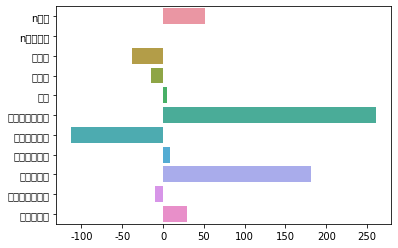

In [47]:
sns.barplot(x=coef.values, y=coef.index)

### permutation importance를 통한 피처 중요도 검토

```
피처 중요도 고려에 대한 설명 제외되어 추가
```

permutation importance에 따른 주요 피처  
+ 단지내주차면수, 총전용면적, 총임대세대수  

In [48]:
from sklearn.inspection import permutation_importance


pmt_columns = ['n지역', 'n공급유형', '공가수', '지하철', '버스', '단지내주차면수',
       '총임대세대수', '평균전용면적', '총전용면적', '평균임대보증금', '평균임대료']

target = '등록차량수'

X_pmt = df_train.loc[:, pmt_columns]
y_pmt = df_train.loc[:, target]

X_pmt_train, X_pmt_val, y_pmt_train, y_pmt_val = train_test_split(X_pmt, y_pmt, random_state=123, test_size=0.1)

model = LinearRegression().fit(X_pmt_train, y_pmt_train)
y_pmt_pred = model.predict(X_pmt_val)

r = permutation_importance(model, X_pmt_val, y_pmt_val, n_repeats=100, random_state=0)

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(X_pmt.columns[i], "     ", np.round(r.importances_mean[i], 4), " +/-", np.round(r.importances_std[i], 5))

단지내주차면수       0.779  +/- 0.15402
총전용면적       0.5273  +/- 0.1295
총임대세대수       0.3702  +/- 0.08431


# 5. 모형 개선

## 1) 가중치 생성

### Cook's D를 활용한 가중치

Cook's Distance : 각 관측값이 전체 최소제곱추정량에 미치는 영향력을 보여주는 통계적 지표 → 값이 클수록 회귀모형에 큰 영향을 주는 샘플(주로 outlier detection에 사용)   

+ Cook's D의 값이 큰 샘플에 작은 가중치, Cook's D의 값이 작은 샘플에 큰 가중치를 부여하면 예측력이 더 높아지지 않을까?
+ 이상치 통제 & 잘 예측하지 못하는 샘플 강조의 기능 예상 

In [51]:
# Cook’s D 값의 크기에 따라 역순으로 0~1 사이의 가중치 생성

from statsmodels.stats.outliers_influence import OLSInfluence
import statsmodels.api as sm

OLS = sm.OLS(y, X_poly)
result = OLS.fit()
influence = OLSInfluence(result)

weight = (influence.cooks_distance[0]).to_numpy()

for i in range(len(weight)):
    if weight[i] < 0.00000001:
        weight[i] = 0.9
    elif weight[i] < 0.0000001:
        weight[i] = 0.8
    elif weight[i] < 0.000001:
        weight[i] = 0.7
    elif weight[i] < 0.00001:
        weight[i] = 0.6
    elif weight[i] < 0.0001:
        weight[i] = 0.5
    elif weight[i] < 0.001:
        weight[i] = 0.4
    elif weight[i] < 0.01:
        weight[i] = 0.3
    elif weight[i] < 0.1:
        weight[i] = 0.2
    else:
        weight[i] = 0.1

NameError: ignored

## 2) Stratified KFold

In [50]:
from sklearn.model_selection import StratifiedKFold

y_cat = pd.cut(y, 10, labels=range(10))

skf = StratifiedKFold(5)
LR = LinearRegression()

preds = []

for tr_id, val_id in skf.split(X_poly, y_cat) : 
    X_tr = X_poly.iloc[tr_id]
    y_tr = y.iloc[tr_id]
    weight_tr = weight[tr_id]

    LR.fit(X_tr, y_tr, sample_weight=weight_tr)
    
    pred = LR.predict(x_val_poly)
    preds.append(pred)

LR_pred = np.mean(preds, axis = 0)

NameError: ignored